In [24]:
#import packages
import numpy as np
from sklearn import linear_model
import random
from math import log
import matplotlib.pyplot as plt

In [33]:
#Define funcitons that will be useful for algorithms simulations 

def Rademacher_matrix(d,n):
    """
    This fucntion generates a Rademacher matrix
    """
    return np.random.choice([-1, 1], size=(d,n))



def Rademacher_matrix_concatenated(d,n):
    """
    This function generates a Rademacher matrix and add a line of ones
    """
    Z=Rademacher_matrix(d,n)
    Last_line_of_ones = np.ones((1, Z.shape[1]))
    return (Z,np.concatenate((Z, Last_line_of_ones), axis=0))



def Lasso_reg(Y_tilde,Z):
    """
    This function gives the solution to the Lasso regression in a multivariate model
    """
    lasso = linear_model.LassoCV(cv=5)
    lasso.fit(Z,Y_tilde )
    g = lasso.coef_
    u=lasso.intercept_
    return(g,u)



def random_vector_unit_spehre(d):
    random_vector = np.random.normal(size=d)
    return(random_vector/np.linalg.norm(random_vector))



def random_unit_vector_on_S_t(d,S_t):
     """
     This function simulates a unit random vector on the spehre S_t
     """
     u_t=np.zeros(d)
     indices=np.array(S_t)
     u_t[indices]=np.random.normal(size=len(indices))
     return(u_t/np.linalg.norm(u_t))
     

In [34]:
def GradiantEstimate(x_t_vect:np.ndarray,d,n,delta,f,S):
    """
    This function corresponds to the pseudo algorithme 1 defined in the paper
    """
    Z=Rademacher_matrix(d,n)
    y_t_vect=np.zeros(n)
    for i in range(n):
        z_i=Z[:, i]
        y_t_vect[i] = f(x_t_vect+delta*z_i,S) #Construct the vector y_t:= f(x_t+delta*z_i)+noise. We suppose that f returns the true output plus noise
    y_tilde=y_t_vect/delta
    (g,u)=Lasso_reg(Y_tilde=y_tilde,Z=Z.T)
    return(g,u)


    
def BGD(delta,T_prime,f,d,y_t,S_t,S,nu=1):
        for t_prime in range (T_prime):
             u_t=random_unit_vector_on_S_t(d=d,S_t=S_t) # select the unit vector u_t uniformly at random
             x_t=y_t+delta*u_t #update x_t at each step where x_t=y_t+delta*u_t.
             c_t=(f(x_t+delta*u_t,S)-f(x_t+delta*u_t,S))/(2*delta)
             y_t=y_t-(nu*c_t*len(S_t)*u_t)
        return x_t




def Successive_selection_algo(T,eta,delta,f,s,B,d,n,S,f_star=0,x_star=0):
    x_t_vect=np.zeros(d)
    S_hat_t=[]
    S_hat_t_minus_1=[1]
    #chi_tilde={x for x in chi if np.linalg.norm(x,ord=1)<=B}
    T_prime=int(T/2)
    simple_regret=[]
    cumulative_regret=[]
    t=0
    x_t_cost=[]
    while len(S_hat_t)<s and t<s and S_hat_t!=S_hat_t_minus_1  : # setting  conditions to stop the while loop 
        
        t=t+1
        g_hat_t,u_t=GradiantEstimate(x_t_vect,d,n,delta,f,S) # Estimate the gradient g_t 
        right_set=[i for i in range(d) if abs(g_hat_t[i]) >= eta]
        S_hat_t_minus_1=S_hat_t.copy() # update S_hat_minus_1
        S_hat_t=S_hat_t_minus_1 + (right_set) # Thresholding
        S_hat_t=list(set(S_hat_t)) #To remove duplicates from S_hat_t
        x_t_minus_one=x_t_vect.copy() # Keep a copy of x_t to use it for the output 
        x_t_vect=BGD(T_prime=T_prime,f=f,d=d,y_t=x_t_vect,S_t=S_hat_t,delta=delta,S=S) # performe the finite difference algorithme that returns x_t
        simple_regret.append(f(x_t_vect,S)-f_star)
        cumulative_regret.append(((sum(cumulative_regret)+f(x_t_vect,S))/(len(cumulative_regret)+1))-f_star)
        x_t_cost.append(np.linalg.norm(x_star-x_t_vect))
        

    if len(S_hat_t)==s:
         return(x_t_vect,simple_regret,cumulative_regret,x_t_cost)
    else:
         return(x_t_minus_one,simple_regret,cumulative_regret,x_t_cost)

In [5]:
# Functions that will be used for testing 
def f_test(x_t,noise=1):#S le support 
    return(np.linalg.norm(x_t)+noise*np.random.normal(0,1,1))
def vect_f_test(x_t, delta, d, n):
    y_t_vecteur = np.zeros(n)
    for i in range(n):
        y_t_vecteur[i] = f_test(x_t, delta, d)
    y_t = f_test(x_t=x_t, delta=0, d=d, noise=0)
    return y_t_vecteur, y_t
def f_test_S(X_t,S,noise=1):
    X_S=np.array([X_t[i] if i in S else 0 for i in range(len(X_t))])
    return(np.linalg.norm(X_S)**2+np.sum(X_S))+noise*np.random.normal(0,1,1)



In [20]:
# Define functions that will be used to estimate hyperparameters

def logarithmic_grid_delta(sigma,s,T,d,H,nb_pnt):
    delta=(((sigma**2)*s*d)/(T*(H**2)))**(1/4)
    begin=delta/nb_pnt
    stop=delta*nb_pnt
    return(np.logspace(np.log10(begin), np.log10(stop), num=nb_pnt))


def logarithmic_grid_eta(C,d,n,nb_pnt):
    eta=(log(d)/n)**(1/2)
    begin=eta/nb_pnt
    stop=eta*nb_pnt
    return(np.logspace(np.log10(begin), np.log10(stop), num=nb_pnt))


def logarithmic_grid_nu(n,nb_pnt):
    nu=1/n
    begin= nu/nb_pnt
    stop= nu/nb_pnt
    return(np.logspace(np.log10(begin), np.log10(stop), num=nb_pnt))





In [6]:
#precising the parameters 
d=100
n=50
delta=0.5
lamda=0.1
x_t=np.random.binomial(1, 1/2,size=(d,))
#x_star = random.choices([1/2], k=d)
s=20
S= random.sample(range(90), s)




In [7]:
x_star=np.zeros(d)
indices=np.array(S)
x_star[indices]=0.5

In [8]:
f_star=f_test_S(x_star,S,noise=0)

In [39]:
f_star

array([15.])

In [35]:
x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=100,eta=1,delta=2,f=f_test_S,s=20,B=2,d=d,n=n,f_star=f_star,S=S,x_star=x_star)

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_2505/3261560253.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(list(range(1,len(cumulative_regret)+1)),np.log(cumulative_regret))


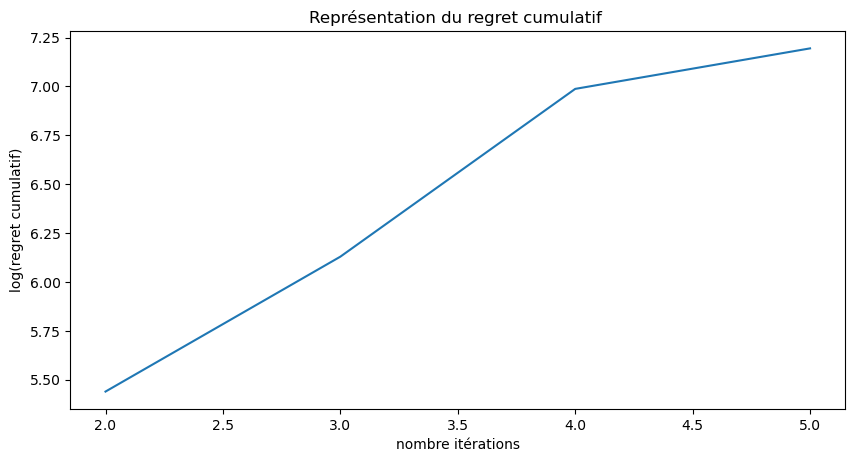

In [30]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(list(range(1,len(cumulative_regret)+1)),np.log(cumulative_regret))
plt.title("Représentation du regret cumulatif ")  # Titre du graphique
plt.ylabel('log(regret cumulatif)')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_2505/1202342585.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(list(range(1,len(simple_regret)+1)),np.log(simple_regret))


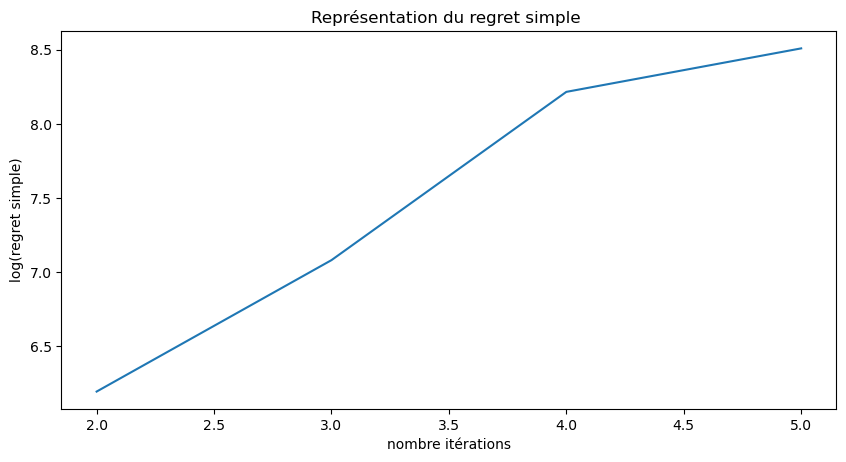

In [31]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(list(range(1,len(simple_regret)+1)),np.log(simple_regret))
plt.title("Représentation du regret simple ")  # Titre du graphique
plt.ylabel('log(regret simple)')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

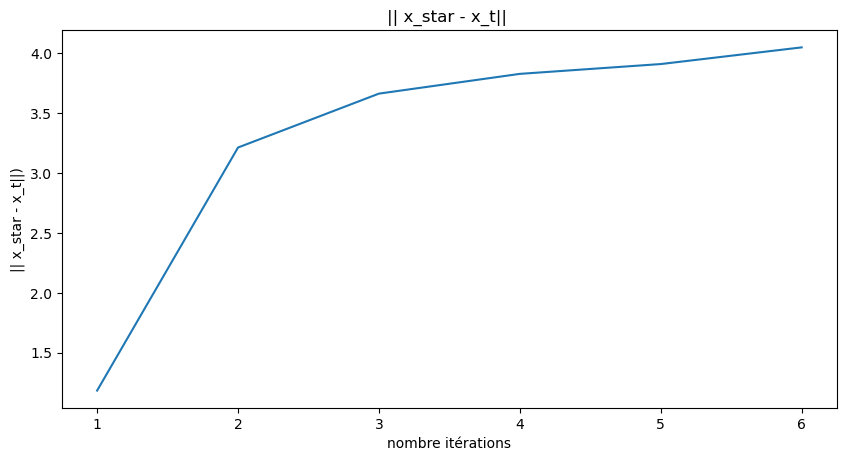

In [36]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(list(range(1,len(x_cost)+1)),np.log(x_cost))
plt.title("|| x_star - x_t|| ")  # Titre du graphique
plt.ylabel('|| x_star - x_t||)')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()